In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat, savemat

In [2]:
filepath = './BB_CVSANS/'
filename_mat = ['S{:d}.mat'.format(i) for i in [1,3,5]]

In [3]:
def sample_potential(parameters,r,ur_hc,d_HS):
    n_sample = 100
    kappa = parameters[1][0][0]
    kappa_std = parameters[1][1][0]
    lnA = parameters[2][0][0]
    lnA_std = parameters[2][1][0]
    
    ur_sample = np.zeros((len(r),n_sample))
    for i in range(n_sample):
        kappa_sample = np.random.normal()*(kappa_std) + kappa
        lnA_sample = np.random.normal()*(lnA_std) + lnA
        ur_sample[:,i] = np.exp(lnA_sample)*np.exp(-(r-d_HS)/(kappa_sample*d_HS))/(r/d_HS) + ur_hc
        
    return ur_sample

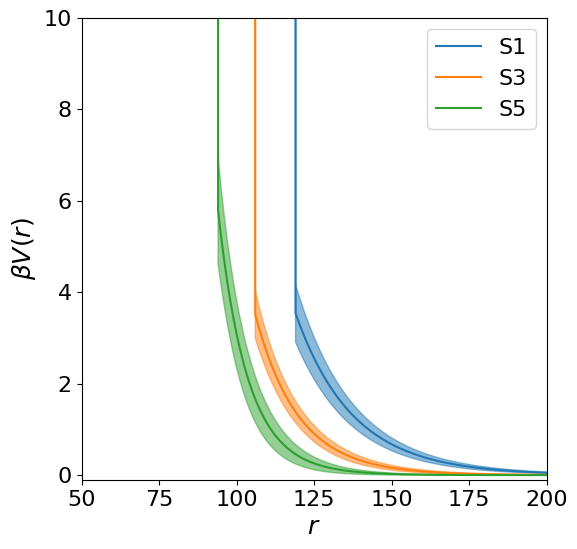

In [4]:
fig = plt.figure(figsize=(6, 6))
ax = plt.subplot(1, 1, 1)
c_cycle = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple',
           'tab:brown','tab:pink','tab:gray','tab:olive','tab:cyan']

r = np.linspace(50, 300, 251)

for i in range(3):
    loaded_data = loadmat(filepath+filename_mat[i])
    parameters = loaded_data['parameters']
    
    d_HS = loaded_data['d_HS'][0]/loaded_data['fp'][0,10]

    ur_hc = 4*500*((2**(1/6)*d_HS/r)**12-(2**(1/6)*d_HS/r)**6-0.25)
    ur_hc[r>=d_HS] = 0
    ur_predict =  np.exp(parameters[2][0][0])*np.exp(-(r-d_HS)/(parameters[1][0][0]*d_HS))/(r/d_HS) + ur_hc
    ur_sample = sample_potential(parameters,r,ur_hc,d_HS)
    ur_std = np.std(ur_sample,axis=1)
    ur_mean = np.mean(ur_sample,axis=1)
    
    ax.fill_between(r,ur_mean+ur_std,ur_mean-ur_std,color=c_cycle[i],alpha=0.5)
    ax.plot(r,ur_mean,color=c_cycle[i],label=filename_mat[i].replace(".mat", ""))

ax.set_ylim(-0.1,10)
ax.set_xlim(50,200)
ax.set_xlabel('$r$',fontsize=18)
ax.set_ylabel(r'$\beta V(r)$',fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.legend(fontsize=16)
plt.show()

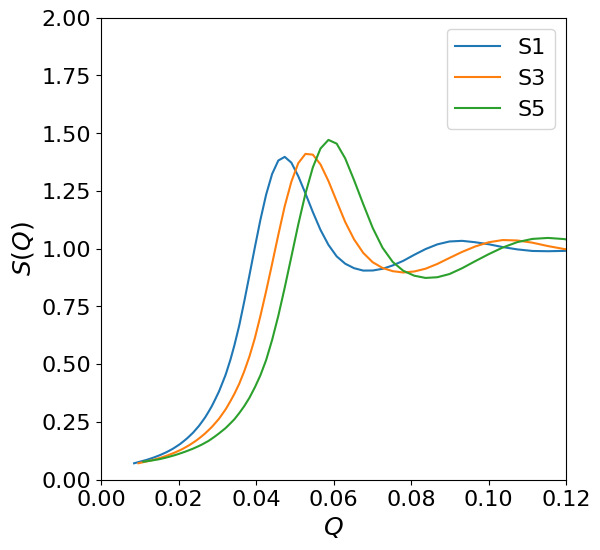

In [5]:
fig = plt.figure(figsize=(6, 6))
ax = plt.subplot(1, 1, 1)
c_cycle = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple',
           'tab:brown','tab:pink','tab:gray','tab:olive','tab:cyan']

r = np.linspace(100, 300, 101)

for i in range(3):
    loaded_data = loadmat(filepath+filename_mat[i])
    SQ = loaded_data['SQ'][0]
    Q = loaded_data['Q'][0]
    d_HS = loaded_data['d_HS'][0]/loaded_data['fp'][0,10]
    index_Q = (Q*d_HS>=1)&(Q*d_HS<=16)
    ax.plot(Q[index_Q],SQ[index_Q],color=c_cycle[i],label=filename_mat[i].replace(".mat", ""))

ax.set_ylim(0,2)
ax.set_xlim(0,0.12)
ax.set_xlabel('$Q$',fontsize=18)
ax.set_ylabel('$S(Q)$',fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.legend(fontsize=16)
plt.show()

In [6]:
for i in range(3):
    loaded_data = loadmat(filepath+filename_mat[i])
    parameters = loaded_data['parameters']
    
    d_HS = (loaded_data['d_HS'][0]/loaded_data['fp'][0,10])[0]
    fp = loaded_data['fp'][0]
    
    lnA, lnA_err = [parameters[2][0][0],parameters[2][1][0]]
    kappa, kappa_err = [parameters[1][0][0]*d_HS,parameters[1][1][0]*d_HS] # 1/kappa (A^-1)
    A = np.exp(lnA)
    A_err = (np.exp(lnA))**(-1)*lnA_err # dA/dlnA*lnA_err
    
    # A = Z^2 e^2 / (epsilon (1+kappaD/2)^2) unit: C^2 / (C^2 J^-1 m^-1) = J m
    epsilon_0 = 8.854e-12 # Vacuum_permittivity (F*m^-1 = Columb^2 J^-1)
    epsilon_water = 80.4*epsilon_0 #  Water permittivity @ 20 degree C
    e = 1.60217663e-19 # Electron charge (Columb)
    kB = 1.380649e-23 # Boltzmann constant (J/K)
    
    Z = np.sqrt(A*(1+d_HS/kappa/2)**2
                *kB*293*(d_HS*1e-9)*epsilon_water/e**2) 
    Z_A = np.sqrt(A*(1+d_HS/kappa/2)**2)/2/A # dZ/dA 
    Z_kappa = -d_HS/2*A*(d_HS/2+kappa)/(kappa**3*np.sqrt(A*(1+d_HS/kappa/2)**2))# dZ/dkappa
    Z_err = np.sqrt(kB*293*(d_HS*1e-9)*epsilon_water/e**2)*(np.sqrt((A_err*Z_A)**2+(kappa_err*Z_kappa)**2))
    

    # fitting parameters
    print(filename_mat[i].replace(".mat", ""))
    print('\nFitting parameters:')
    print('d_HS = {} (A)'.format(d_HS))
    print('C = {} (1/cm)'.format(fp[0]))
    print('I_inc = {} (1/cm)'.format(fp[1]))
    print('R_1 = {} (A)'.format(fp[2]*d_HS))
    print('R_2 = {} (A)'.format(fp[3]*d_HS))
    print('sigma_1 = {} (A)'.format(fp[4]*d_HS))
    print('sigma_2 = {} (A)'.format(fp[5]*d_HS))
    print('rc = {}'.format(fp[6]))
    print('lv_0 = {}'.format(fp[7]))
    print('lv_1 = {}'.format(fp[8]))
    print('lv_2 = {}'.format(fp[9]))
    print('\nInteraction parameters from GPR: \n--- eta = {:0.4f} +- {:0.4f} \n--- 1/kappa = {:0.4f} +- {:0.4f} (A)\n--- lnA = {:0.4f} +- {:0.4f}\n'
          .format(parameters[0][0][0],parameters[0][1][0],
                  parameters[1][0][0]*d_HS,parameters[1][1][0]*d_HS,
                  parameters[2][0][0],parameters[2][1][0]))
    print('--- Z = {:0.4f} +- {:0.4f} \n'
          .format(Z,Z_err))

S1

Fitting parameters:
d_HS = 118.10262889543543 (A)
C = 71.64715040406911 (1/cm)
I_inc = 1.6919315603248812 (1/cm)
R_1 = 33.399247081124756 (A)
R_2 = 55.45426879082895 (A)
sigma_1 = 15.882077792947236 (A)
sigma_2 = 23.378506863645477 (A)
rc = 0.37482461120324606
lv_0 = 0.15902700301495748
lv_1 = 0.14598718782632927
lv_2 = 0.4

Interaction parameters from GPR: 
--- eta = 0.2249 +- 0.0004 
--- 1/kappa = 21.8206 +- 1.4298 (A)
--- lnA = 1.2653 +- 0.1584

--- Z = 25.3974 +- 1.2257 

S3

Fitting parameters:
d_HS = 105.46647505517477 (A)
C = 50.95672603558867 (1/cm)
I_inc = 0.9135653283048962 (1/cm)
R_1 = 32.96598436640552 (A)
R_2 = 83.33333333310065 (A)
sigma_1 = 20.637484524795003 (A)
sigma_2 = 33.33333333331037 (A)
rc = 0.8193243168562189
lv_0 = 0.10638340975043184
lv_1 = 0.12816919607004076
lv_2 = 0.4

Interaction parameters from GPR: 
--- eta = 0.2330 +- 0.0005 
--- 1/kappa = 16.3797 +- 1.7154 (A)
--- lnA = 1.3023 +- 0.1632

--- Z = 27.8334 +- 2.2304 

S5

Fitting parameters:
d_HS = 93